In [1]:
import pandas as pd
import spacy
import sqlite3
from sqlalchemy import create_engine

from spacytextblob.spacytextblob import SpacyTextBlob

from goodreads_book_scraper import get_listopia
from book_importer import BookImporter
from language_analysis import Book
from similarity import SimilarityChecker


# Data Pipeline

## Get a list of books from GoodReads

In [2]:

# Get the URL from the GoodReads website
best_books_ever_url = 'https://www.goodreads.com/list/show/1.Best_Books_Ever'
large_book_list_url = 'https://www.goodreads.com/list/show/952.1001_Books_You_Must_Read_Before_You_Die'

# Scrape the website and return lists of books, authors and average review
goodreads_list, author_list, review_list = get_listopia(large_book_list_url)



In [3]:
# Empty book_data list to store the books in
book_data = []

# Iterate through the book list and check if it is on Gutenberg
for count, book in enumerate(goodreads_list):
    file_path, book_id = BookImporter.gutendex(book, author_list[count])
    
    # Store the book in the book list
    if file_path not in book_data:
        book_data.append({'GutenbergID': book_id, 'Title': book, 'Author': author_list[count], 'Review': review_list[count], 'FilePath': file_path})


In [4]:
# Convert the book list into a pandas and check for missing values
book_data = pd.DataFrame(book_data)
book_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GutenbergID  100 non-null    int64 
 1   Title        100 non-null    object
 2   Author       100 non-null    object
 3   Review       100 non-null    object
 4   FilePath     42 non-null     object
dtypes: int64(1), object(4)
memory usage: 4.0+ KB


### Remove Duplicates (if any)

In [5]:
# Check for duplicates
duplicates = book_data.duplicated()

duplicate_rows = book_data[duplicates]
print(duplicate_rows)

Empty DataFrame
Columns: [GutenbergID, Title, Author, Review, FilePath]
Index: []


In [6]:
# If there are any duplicate values (check by title and author), remove them
book_data = book_data.drop_duplicates(subset=['Title', 'Author'], keep='first')

In [8]:
# Check the dataframe
print(book_data.head())

    GutenbergID                                        Title   
0             0                        To Kill a Mockingbird  \
1          1342                          Pride and Prejudice   
2             0                                         1984   
3         70333                        The Lord of the Rings   
4         64317                             The Great Gatsby   
..          ...                                          ...   
95            0                                    The Idiot   
96            0                          The Virgin Suicides   
97            0                                   The Plague   
98          110                    Tess of the D'Urbervilles   
99            0  Things Fall Apart (The African Trilogy, #1)   

                 Author Review                            FilePath  
0            Harper Lee   4.27                                None  
1           Jane Austen   4.28        data/Pride_and_Prejudice.txt  
2         George Orwell 

In [9]:
# Get a list of unique author names
author_list = book_data['Author'].unique()
author_list_df = pd.DataFrame({'Name': author_list})

print(author_list_df)

                   Name
0            Harper Lee
1           Jane Austen
2         George Orwell
3        J.R.R. Tolkien
4   F. Scott Fitzgerald
..                  ...
72          Jack London
73      Boris Pasternak
74            Anonymous
75         Thomas Hardy
76        Chinua Achebe

[77 rows x 1 columns]


## Add data to SQL database

### Start up SQL

In [10]:
# Start the SQL database 
conn = sqlite3.connect('databases/book_repository.db')
cursor = conn.cursor()
engine = create_engine('sqlite:///databases/book_repository.db')


### Create the tables (Commented out after the first iteration)

In [11]:
# Create Authors table
with engine.begin() as connection:
    conn.execute('''
        CREATE TABLE IF NOT EXISTS Authors(
            AuthorID INTEGER PRIMARY KEY AUTOINCREMENT,
            Name VARCHAR
        )
    ''')

In [24]:
# Create Gutenberg table
with engine.begin() as connection:
    conn.execute('''
    CREATE TABLE IF NOT EXISTS Gutenberg(
        GutenbergID INTEGER,
        FilePath VARCHAR
        );
    ''')

In [13]:
# Create Books table
with engine.begin() as connection:
    conn.execute('''
    CREATE TABLE IF NOT EXISTS Books(
        GutenbergID VARCHAR(7),
        Title VARCHAR,
        AuthorID INTEGER,
        Review DOUBLE,
        FOREIGN KEY (GutenbergID) REFERENCES Gutenberg(GutenbergID)
        FOREIGN KEY (AuthorID) REFERENCES Authors(AuthorID)
        );
''')


### Put the data in a temporary table

In [26]:
# Turn the books data into a temporary SQL table
book_data.to_sql('temp_books', conn, if_exists='replace', index=False)

100

In [15]:
# Turn the author list into a temporary SQL table
author_list_df.to_sql('temp_authors', conn, if_exists='replace', index=False)

77

In [16]:
# Insert the author names into the table, ignore repetitions
with engine.begin() as connection:
    conn.execute("""
        INSERT INTO Authors (Name)
        SELECT DISTINCT LOWER(t.Name)
        FROM temp_authors AS t
        LEFT JOIN Authors AS a ON LOWER(t.Name) = LOWER(a.Name)
        WHERE a.Name IS NULL
    """)

In [27]:
# Insert the GutenbergID if it exists
with engine.begin() as connection:
    conn.execute('''
        INSERT INTO Gutenberg (GutenbergID, FilePath)
        SELECT t.GutenbergID, t.FilePath
        FROM temp_books as t
        WHERE t.FilePath IS NOT NULL
    ''')

    # If there is not GutenbergID, it will reference this
    conn.execute('''
        INSERT INTO Gutenberg (GutenbergID, FilePath)
        VALUES (0, 'Not Available')    
    ''')

In [18]:
# Insert the rest of the Book data, with the foreign keys
with engine.begin() as connection:
    conn.execute('''
        INSERT INTO Books (GutenbergID, Title, AuthorID, Review)
        SELECT t.GutenbergID, t.Title, a.AuthorID, t.Review
        FROM temp_books AS t
        LEFT JOIN Authors AS a ON LOWER(t.Author) = LOWER(a.Name)
        LEFT JOIN Books AS b ON t.GutenbergID = b.GutenbergID
        WHERE b.GutenbergID IS NULL
    ''')

### Drop the temporary Table

In [19]:
# Drop the temporary tables
with engine.begin() as connection:
    conn.execute("DROP TABLE IF EXISTS temp_books")
    conn.execute('DROP TABLE IF EXISTS temp_authors')


In [36]:
# Check to see if the Data was inserted correctly
cursor.execute('''
    SELECT Books.Title, Authors.Name, Books.GutenbergID
    FROM Books
    LEFT OUTER JOIN Authors ON Books.AuthorID = Authors.AuthorID
''')

rows = cursor.fetchall()
for row in rows:
    print(f'{row[0]}: {row[1]}, {row[2]}')


To Kill a Mockingbird: harper lee, 0
Pride and Prejudice: jane austen, 1342
1984: george orwell, 0
The Lord of the Rings: j.r.r. tolkien, 70333
The Great Gatsby: f. scott fitzgerald, 64317
Jane Eyre: charlotte brontë, 1260
The Little Prince: antoine de saint-exupéry, 0
Animal Farm: george orwell, 0
The Hobbit (The Lord of the Rings, #0): j.r.r. tolkien, 0
The Catcher in the Rye: j.d. salinger, 0
The Picture of Dorian Gray: oscar wilde, 174
Lord of the Flies: william golding, 0
Wuthering Heights: emily brontë, 768
Little Women: louisa may alcott, 37106
The Hitchhiker's Guide to the Galaxy (The Hitchhiker's Guide to the Galaxy, #1): douglas adams, 39
Of Mice and Men: john steinbeck, 0
Brave New World: aldous huxley, 0
Gone with the Wind: margaret mitchell, 0
The Count of Monte Cristo: alexandre dumas, 1184
Crime and Punishment: fyodor dostoevsky, 0
One Hundred Years of Solitude: gabriel garcía márquez, 0
Les Misérables: victor hugo, 135
The Handmaid’s Tale (The Handmaid's Tale, #1): marg

In [32]:
# Check if the Gutenberg table was inserted correctly
cursor.execute('SELECT * FROM Gutenberg')

rows = cursor.fetchall()
for row in rows:
    print(f'{row[0]:>7}: {row[1]}')

   1342: data/Pride_and_Prejudice.txt
  70333: data/The_Lord_of_the_Rings.txt
  64317: data/The_Great_Gatsby.txt
   1260: data/Jane_Eyre.txt
    174: data/The_Picture_of_Dorian_Gray.txt
    768: data/Wuthering_Heights.txt
  37106: data/Little_Women.txt
     39: data/The_Hitchhiker's_Guide_to_the_Galaxy_(The_Hitchhiker's_Guide_to_the_Galaxy,_#1).txt
   1184: data/The_Count_of_Monte_Cristo.txt
    135: data/Les_Misérables.txt
    345: data/Dracula.txt
   1399: data/Anna_Karenina.txt
  32325: data/The_Adventures_of_Huckleberry_Finn.txt
   1400: data/Great_Expectations.txt
    161: data/Sense_and_Sensibility.txt
   1661: data/The_Adventures_of_Sherlock_Holmes_(Sherlock_Holmes,_#3).txt
  13923: data/The_Old_Man_and_the_Sea.txt
  25344: data/The_Scarlet_Letter.txt
   2600: data/War_and_Peace.txt
    158: data/Emma.txt
     46: data/A_Christmas_Carol.txt
   2500: data/Siddhartha.txt
    120: data/Treasure_Island.txt
    105: data/Persuasion.txt
     43: data/Dr._Jekyll_and_Mr._Hyde.txt
     9

In [38]:
# Stop the SQL server
conn.close()

# Analysis

## Load the NLP and add TextBlob to it

In [39]:
# Load the large dataset and add the TextBlob pipeline
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe('spacytextblob')

# Create a books list to store the Book objects
books = []

## Read the files and analyse the novels

### Jekyll and Hyde

In [40]:
# Import Jekyll and Hyde from Gutenberg
BookImporter.get_book(43, 'Jekyll and Hyde')

# Read the txt file and create a Book object
with open('data\Jekyll_and_Hyde.txt', 'r', encoding='UTF-8') as file:
    jekyll_hyde = Book('Jekyll and Hyde', file.read())

# Denote the chapter markers in a regex expression
chapter_markers = r'((\nSTORY OF THE DOOR)|(\nSEARCH FOR MR. HYDE)|(\nDR. JEKYLL WAS QUITE AT EASE)|(\nTHE CAREW MURDER CASE)|(\nINCIDENT OF THE LETTER)|(\nINCIDENT OF DR. LANYON)|(\nINCIDENT AT THE WINDOW)|(\nTHE LAST NIGHT)|(\nDR. LANYON’S NARRATIVE)|(\nHENRY JEKYLL’S FULL STATEMENT OF THE CASE))'


In [41]:
# Split the book into chapters
jekyll_hyde.split_into_chapters(chapter_markers)


Number of chapters: 10


In [42]:
# Conduct NLP analysis sentence by sentence
jekyll_hyde.do_nlp(nlp)


In [43]:
# Do NLP on each chapter
jekyll_hyde.chapter_nlp(nlp)


In [44]:
# Show sentiment analysis of the entire text
jekyll_hyde.blobify()

Blobby Statistics for Jekyll and Hyde
Whole Text Polarity:			0.06765569084634399
Whole Text Subjectivity:		0.4868429108820682



Basic Statistics for Jekyll and Hyde:
	Total Tokens:			33005
	Unique Words:			17301
	Average Sentence Length:	31.70509125840538
	Average Sentence Polarity:	0.04004205728801255
	Average Sentence Subjectivity:	0.3577003946792897

Sentence with highest polarity (1.0):
Thereupon, I arranged my clothes as best I could, and summoning a
passing hansom, drove to an hotel in Portland Street, the name of which
I chanced to remember.

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

Sentence with lowest polarity (-1.0):
At that time my virtue slumbered; my
evil, kept awake by ambition, was alert and swift to seize the
occasion; and the thing that was projected was Edward Hyde.

	Tokens: evil
		Polarity: -1.0
		Subjectivity: 1.0



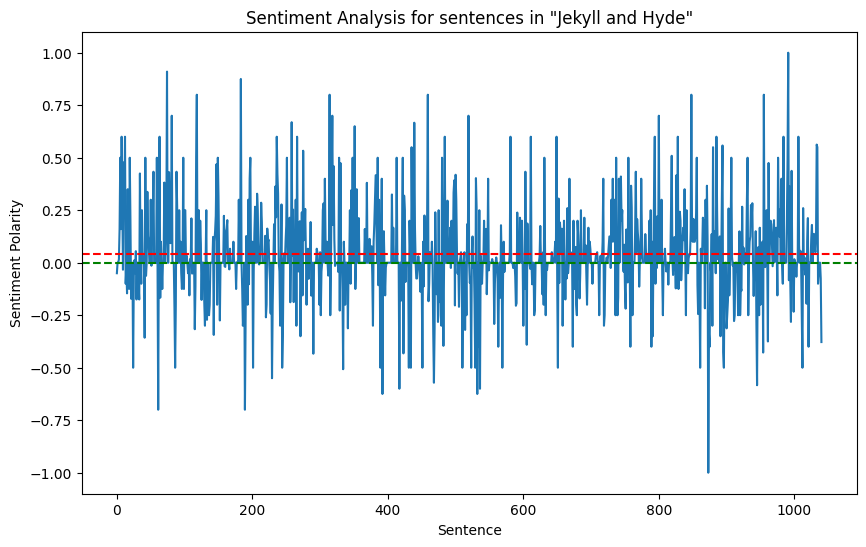

<Figure size 1000x600 with 0 Axes>

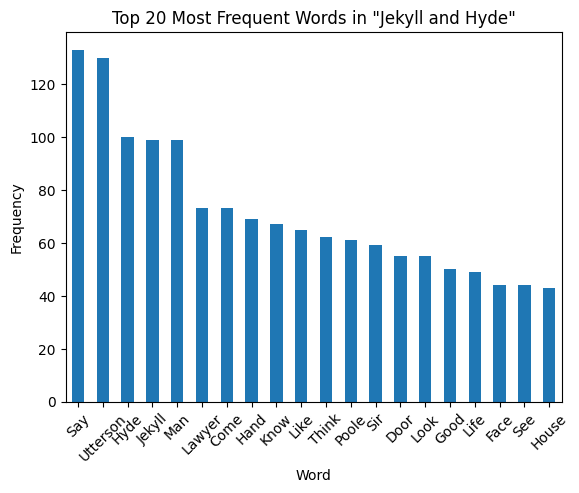

In [45]:
# Show the analysis of the book
jekyll_hyde.get_analysis()

Median Sentiment: 0.09171992663517003


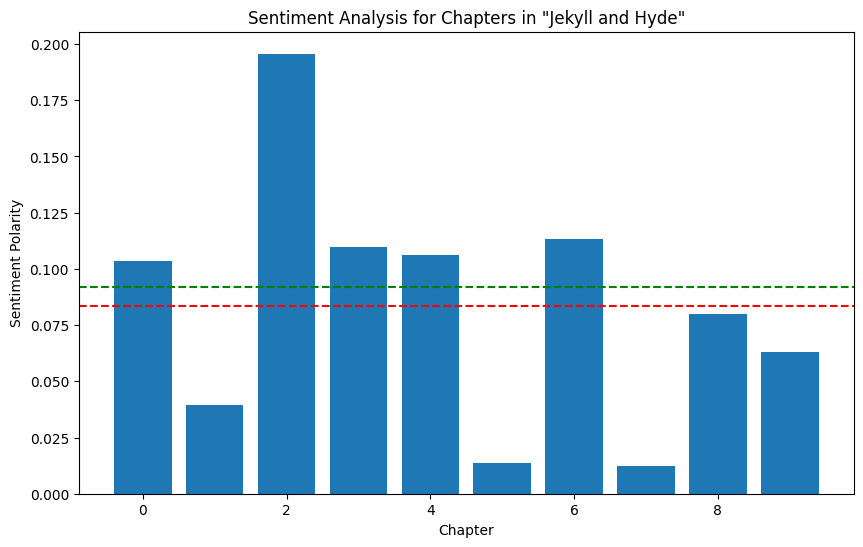

The most positive chapter was Chapter 3: 0.19568254943254937
	Tokens: later
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: pleasant
		Polarity: 0.7333333333333333
		Subjectivity: 0.9666666666666667

	Tokens: old
		Polarity: 0.1
		Subjectivity: 0.2

	Tokens: intelligent
		Polarity: 0.8
		Subjectivity: 0.9

	Tokens: reputable
		Polarity: 0.5
		Subjectivity: 0.8

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: contrived
		Polarity: -0.5
		Subjectivity: 0.75

	Tokens: behind
		Polarity: -0.4
		Subjectivity: 0.7

	Tokens: no, new
		Polarity: -0.06818181818181818
		Subjectivity: 0.45454545454545453

	Tokens: many
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: liked
		Polarity: 0.6
		Subjectivity: 0.8

	Tokens: liked
		Polarity: 0.6
		Subjectivity: 0.8

	Tokens: loved
		Polarity: 0.7
		Subjectivity: 0.8

	Tokens: dry
		Polarity: -0.0666666666666666

In [46]:
# Show the sentiment analysis by chapter
jekyll_hyde.chapter_analysis()


In [47]:
# Add the book to the book object list
books.append(jekyll_hyde)

### Dracula

In [48]:
with open('data\Dracula.txt', 'r', encoding='UTF-8') as file:
    dracula = Book('Dracula', file.read())
chapter_markers = r'(PREFACE.)|(LETTER I+\.)|(CHAPTER [IVXLCDM]+\n)'



In [49]:
dracula.split_into_chapters(chapter_markers)


Number of chapters: 27


In [50]:
dracula.do_nlp(nlp)


In [51]:
dracula.chapter_nlp(nlp)


In [52]:
dracula.blobify()

Blobby Statistics for Dracula
Whole Text Polarity:			0.0753165823494414
Whole Text Subjectivity:		0.5029390985523027



Basic Statistics for Dracula:
	Total Tokens:			204503
	Unique Words:			102195
	Average Sentence Length:	24.875684223330495
	Average Sentence Polarity:	0.05055290442560446
	Average Sentence Subjectivity:	0.35152529301759905

Sentence with highest polarity (1.0):
I was told that this road is in summertime
excellent, but that it had not yet been put in order after the winter
snows.

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
How was it that all the people at Bistritz and on the
coach had some terrible fear for me?

	Tokens: terrible
		Polarity: -1.0
		Subjectivity: 1.0



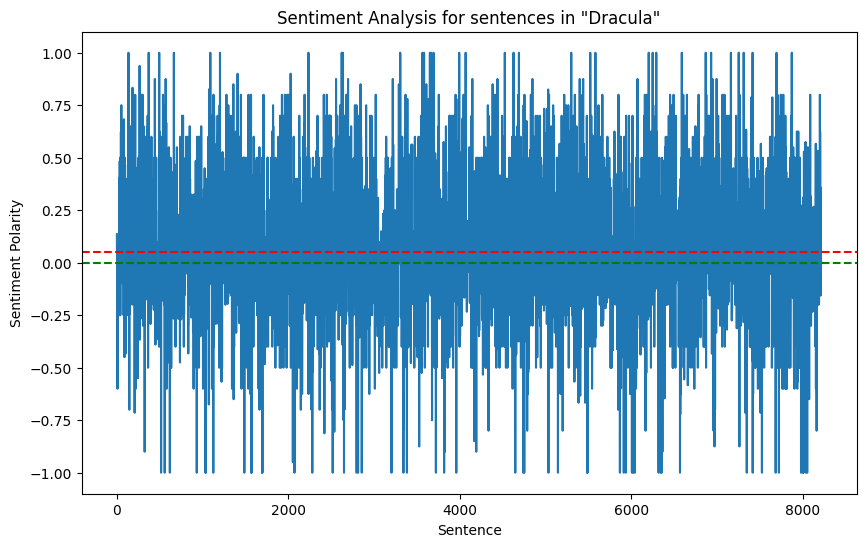

<Figure size 1000x600 with 0 Axes>

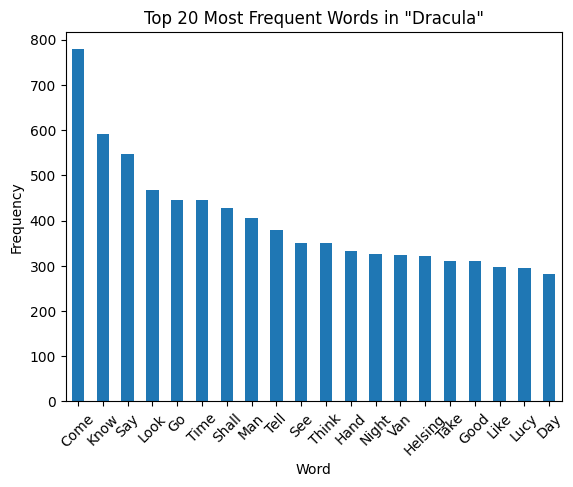

In [53]:
dracula.get_analysis()


Median Sentiment: 0.07448042068178261


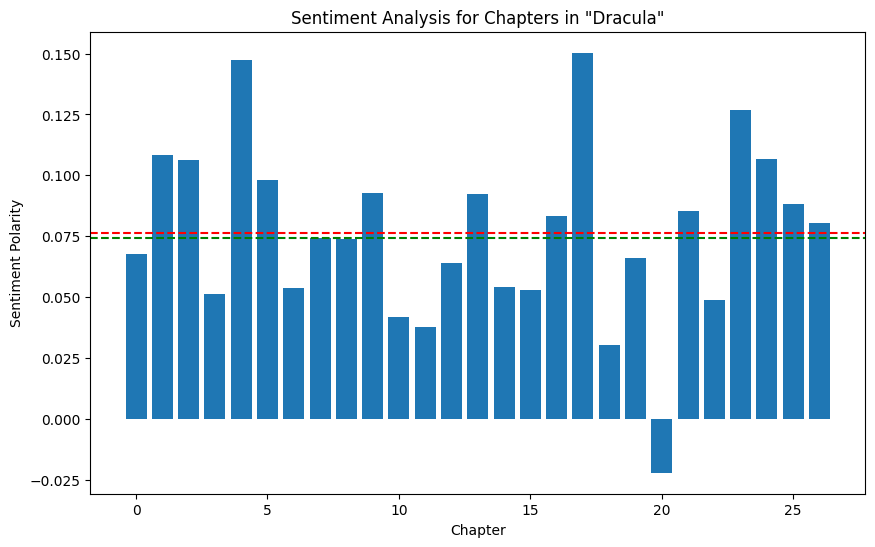

The most positive chapter was Chapter 18: 0.15034064503652142
	Tokens: not, only
		Polarity: -0.0
		Subjectivity: 1.0

	Tokens: various
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: wonderful
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: honestly
		Polarity: 0.6
		Subjectivity: 0.9

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: old
		Polarity: 0.1
		Subjectivity: 0.2

	Tokens: much, !
		Polarity: 0.25
		Subjectivity: 0.2

	Tokens: appealing
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: pretty
		Polarity: 0.25
		Subjectivity: 1.0

	Tokens: no, possible
		Polarity: -0.0
		Subjectivity: 1.0

	Tokens: simply
		Polarity: 0.0
		Subjectivity: 0.35714285714285715

	Tokens: wants
		Polarity: 0.2
		Subjectivity: 0.1

	Tokens: very
		Polarity: 0.2
		Subjectivity: 0.3

	Tokens: tidy
		Polarity: 0.6
		Subjectivity: 0.8

	Tokens: simply
		Polarity: 0.0
		Subjectivity: 0.35714285714285715

	Tokens: evident
		Polarity: 0.25
		Subjectivity: 0.25

	Tokens: disgusting
		Pol

In [54]:
dracula.chapter_analysis()
books.append(dracula)

### Frankenstein

In [55]:
BookImporter.get_book(84, 'Frankenstein')
with open('data\Frankenstein.txt', 'r', encoding='UTF-8') as file:
    frankenstein = Book('Frankenstein', file.read())

chapter_markers = r'\n((Letter .)|(Chapter .+))'
frankenstein.split_into_chapters(chapter_markers)


Number of chapters: 28


In [56]:
frankenstein.do_nlp(nlp)


In [57]:
frankenstein.chapter_nlp(nlp)


In [58]:
frankenstein.blobify()


Blobby Statistics for Frankenstein
Whole Text Polarity:			0.10086658707213995
Whole Text Subjectivity:		0.5395477185484239



Basic Statistics for Frankenstein:
	Total Tokens:			92217
	Unique Words:			47493
	Average Sentence Length:	28.78183520599251
	Average Sentence Polarity:	0.06708833331853943
	Average Sentence Subjectivity:	0.40679099398935653

Sentence with highest polarity (1.0):
Farewell, my dear, excellent Margaret.

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
But
that would be a cruel kindness, and I dare not do it.

	Tokens: cruel
		Polarity: -1.0
		Subjectivity: 1.0



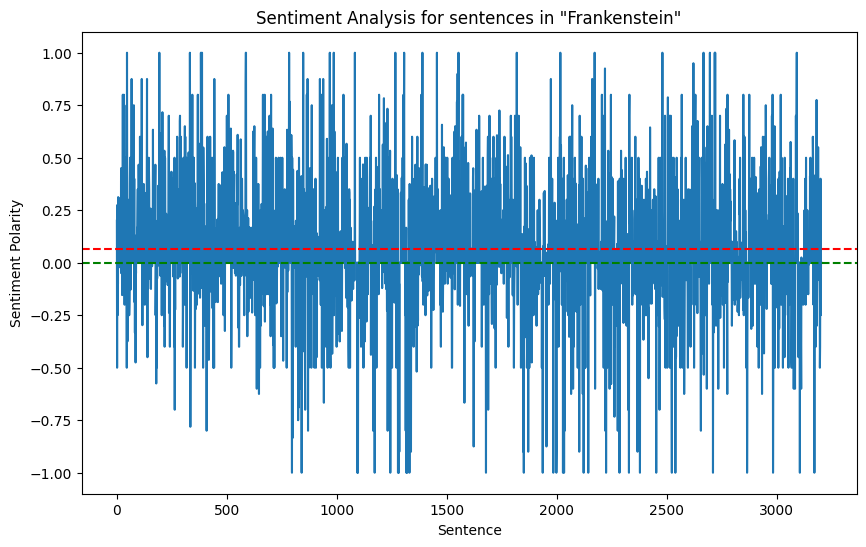

<Figure size 1000x600 with 0 Axes>

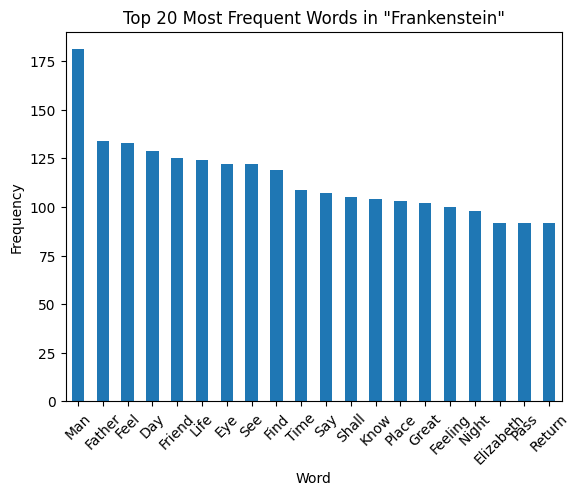

In [59]:
frankenstein.get_analysis()


Median Sentiment: 0.1155247116626006


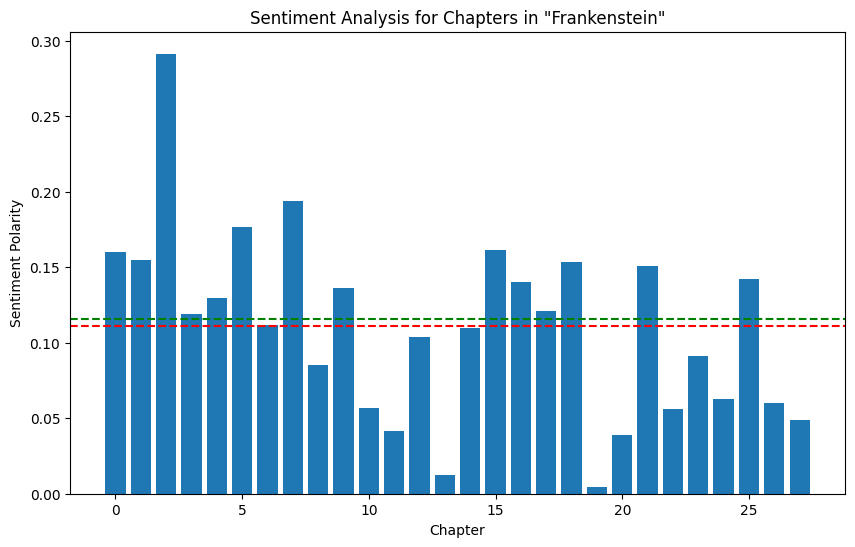

The most positive chapter was Chapter 3: 0.2913933747412008
	Tokens: few
		Polarity: -0.2
		Subjectivity: 0.1

	Tokens: advanced
		Polarity: 0.4
		Subjectivity: 0.6

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: fortunate
		Polarity: 0.4
		Subjectivity: 0.7

	Tokens: many
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: bold
		Polarity: 0.3333333333333333
		Subjectivity: 0.6666666666666666

	Tokens: apparently, firm
		Polarity: -0.2
		Subjectivity: 0.4

	Tokens: very, high
		Polarity: 0.20800000000000002
		Subjectivity: 0.702

	Tokens: warm
		Polarity: 0.6
		Subjectivity: 0.6

	Tokens: southern
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: not, expected
		Polarity: 0.05
		Subjectivity: 0.4

	Tokens: stiff
		Polarity: -0.21428571428571427
		Subjectivity: 0.5

	Tokens: experienced
		Polarity: 0.8
		Subjectivity: 0.9

	Tokens: worse
		Polarity: -0.4
		Subjectivity: 0.6

	Tokens: own
		Polarity: 0.6
		Subjectivity

In [60]:
frankenstein.chapter_analysis()
books.append(frankenstein)

### The Turn of the Screw

In [61]:
BookImporter.get_book(209, 'The Turn of the Screw')
with open('data\The_Turn_of_the_Screw.txt', 'r', encoding='UTF-8') as file:
    turn_of_the_screw = Book('The Turn of the Screw', file.read())

chapter_markers = r'((\nI\n)|(\nII)|(\nIII)|(\nIV)|(\nV)|(\nVI)|(\nVII)|(\nVIII)|(\nIX)|(\nX)|(\nXI)|(\nXII)|(\nXIII)|(\nXIV)|(\nXV)|(\nXVI)|(\nXVII)|(\nXVIII)|(\nXIX)|(\nXX)|(\nXXI)|(\nXXII)|(\nXXIII)|(\nXXIV))'


In [62]:
turn_of_the_screw.split_into_chapters(chapter_markers)


Number of chapters: 24


In [63]:
turn_of_the_screw.do_nlp(nlp)


In [64]:
turn_of_the_screw.chapter_nlp(nlp)


In [65]:
turn_of_the_screw.blobify()


Blobby Statistics for The Turn of the Screw
Whole Text Polarity:			0.08209676744527038
Whole Text Subjectivity:		0.5134243159546995



Basic Statistics for The Turn of the Screw:
	Total Tokens:			56092
	Unique Words:			27524
	Average Sentence Length:	26.941402497598464
	Average Sentence Polarity:	0.05197351025916808
	Average Sentence Subjectivity:	0.36126593514650873

Sentence with highest polarity (1.0):
“For dreadful—dreadfulness!”

“Oh, how delicious!” cried one of the women.



	Tokens: delicious, !
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
It’s quite too
horrible.”

	Tokens: horrible
		Polarity: -1.0
		Subjectivity: 1.0



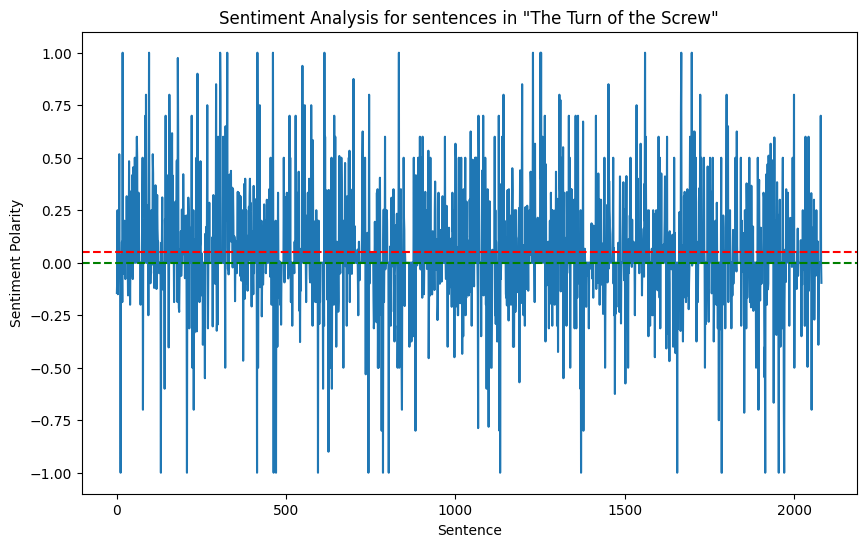

<Figure size 1000x600 with 0 Axes>

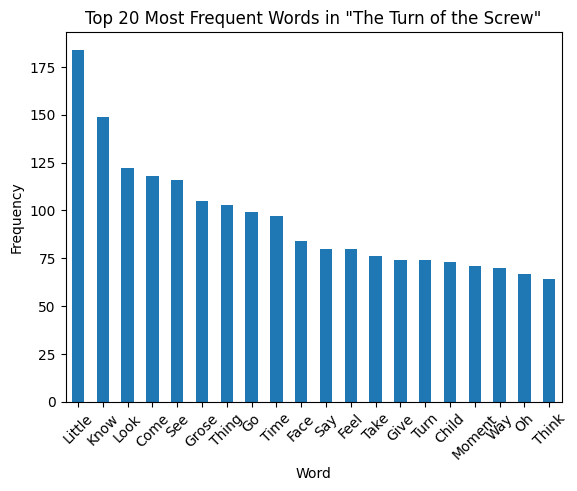

In [66]:
turn_of_the_screw.get_analysis()


Median Sentiment: 0.06916273265484042


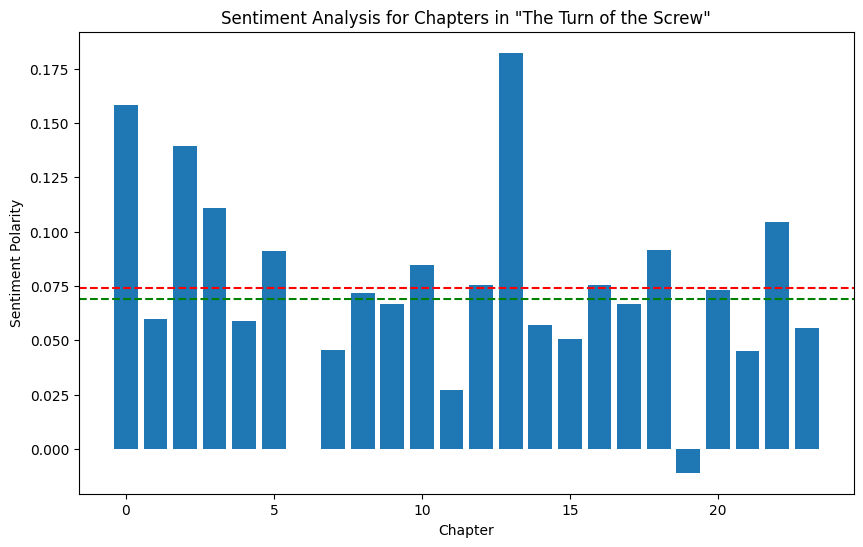

The most positive chapter was Chapter 14: 0.1823420120931183
	Tokens: certain
		Polarity: 0.21428571428571427
		Subjectivity: 0.5714285714285714

	Tokens: little
		Polarity: -0.1875
		Subjectivity: 0.5

	Tokens: crisp
		Polarity: 0.25
		Subjectivity: 0.4166666666666667

	Tokens: clear
		Polarity: 0.10000000000000002
		Subjectivity: 0.3833333333333333

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: bright
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: sharp
		Polarity: -0.125
		Subjectivity: 0.75

	Tokens: gay
		Polarity: 0.4166666666666667
		Subjectivity: 0.5833333333333334

	Tokens: odd
		Polarity: -0.16666666666666666
		Subjectivity: 0.25

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: particularly
		Polarity: 0.16666666666666666
		Subjectivity: 0.3333333333333333

	Tokens: very
		Polarity: 0.2
		Subjectivity: 0.3

	Tokens: little
		Polarity: -0.1875
		Subjectivity: 0.5

	Tokens: other
		Polarity: -0.125
		Subjec

In [67]:
turn_of_the_screw.chapter_analysis()
books.append(turn_of_the_screw)

### Romeo and Juliet

In [68]:
BookImporter.get_book(1513, 'Romeo and Juliet')
with open('data\Romeo_and_Juliet.txt', 'r', encoding='UTF-8') as file:
    romeo_and_juliet = Book('Romeo and Juliet', file.read())

chapter_markers = r'(THE PROLOGUE\n)|(SCENE I. A public place)|(SCENE II. A Street)|(SCENE III. Room in Capulet’s House)|(SCENE IV. A Street)|(SCENE V. A Hall in Capulet’s House)|(ACT II\n\n)|(SCENE I. An open place adjoining Capulet’s Garden)|(SCENE II. Capulet’s Garden)|(SCENE III. Friar Lawrence’s Cell)|(SCENE IV. A Street)|(SCENE V. Capulet’s Garden)|(SCENE VI. Friar Lawrence’s Cell)|(SCENE I. A public Place)|(SCENE II. A Room in Capulet’s House)|(SCENE III. Friar Lawrence’s cell)|(SCENE IV. A Room in Capulet’s House)|(SCENE V. An open Gallery to Juliet’s Chamber, overlooking the Garden)|(SCENE I. Friar Lawrence’s Cell)|(SCENE II. Hall in Capulet’s House)|(SCENE III. Juliet’s Chamber)|(SCENE IV. Hall in Capulet’s House)|(SCENE V. Juliet’s Chamber; Juliet on the bed)|(SCENE I. Mantua. A Street)|(SCENE II. Friar Lawrence’s Cell)|(SCENE III. A churchyard; in it a Monument belonging to the Capulets)'


In [69]:
romeo_and_juliet.split_into_chapters(chapter_markers)


Number of chapters: 26


In [70]:
romeo_and_juliet.do_nlp(nlp)


In [71]:
romeo_and_juliet.chapter_nlp(nlp)


In [72]:
romeo_and_juliet.blobify()


Blobby Statistics for Romeo and Juliet
Whole Text Polarity:			0.15117404453509595
Whole Text Subjectivity:		0.5303400948667142



Basic Statistics for Romeo and Juliet:
	Total Tokens:			37463
	Unique Words:			23982
	Average Sentence Length:	14.74340810704447
	Average Sentence Polarity:	0.0592589366007663
	Average Sentence Subjectivity:	0.20815429015455014

Sentence with highest polarity (1.0):
Your plantain leaf is excellent for that.

BENVOLIO.


	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
Yea, is the worst well?

	Tokens: worst
		Polarity: -1.0
		Subjectivity: 1.0



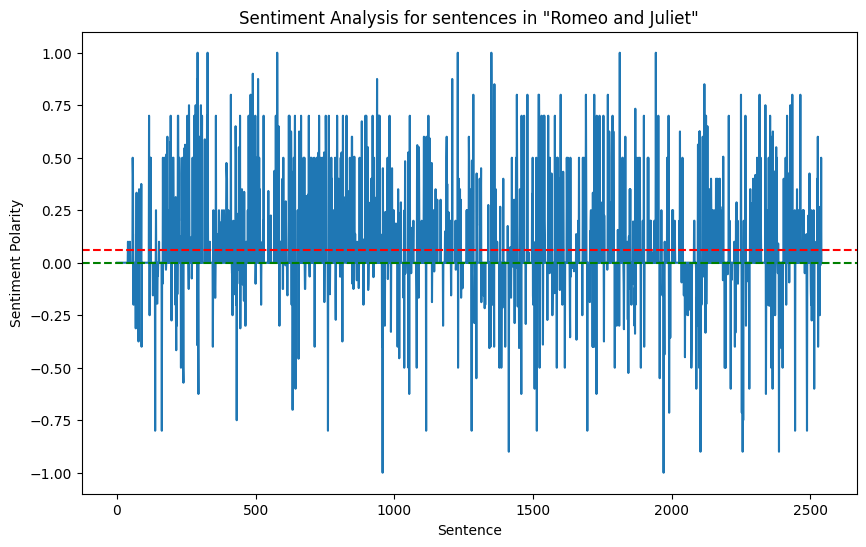

<Figure size 1000x600 with 0 Axes>

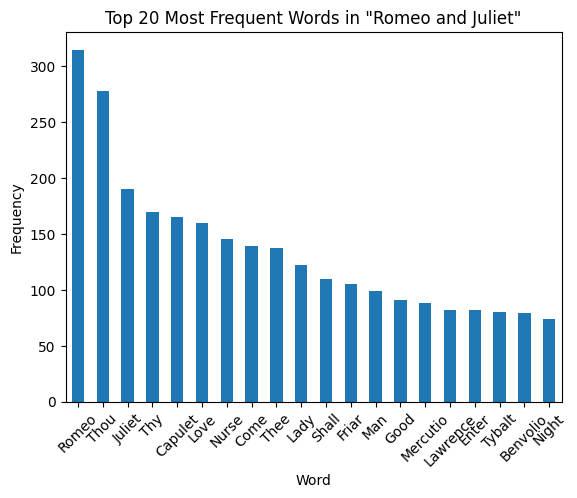

In [73]:
romeo_and_juliet.get_analysis()


Median Sentiment: 0.14671128556092322


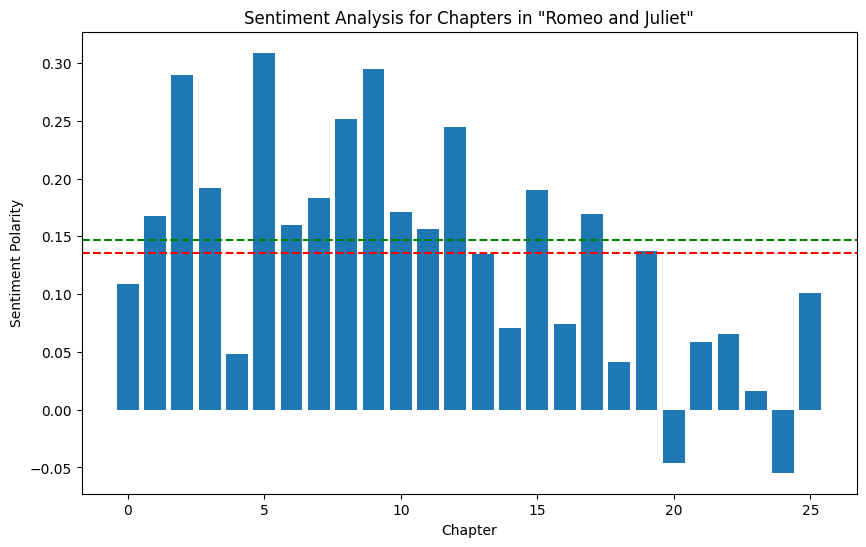

The most positive chapter was Chapter 6: 0.30892668776371296
	Tokens: first, !, !
		Polarity: 0.390625
		Subjectivity: 0.3333333333333333

	Tokens: second
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: good, !
		Polarity: 0.875
		Subjectivity: 0.6000000000000001

	Tokens: second
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: ready
		Polarity: 0.2
		Subjectivity: 0.5

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: second
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: welcome
		Polarity: 0.8
		Subjectivity: 0.9

	Tokens: dainty
		Polarity: 0.9
		Subjectivity: 1.0

	Tokens: near
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: welcome, !
		Polarity: 1.0
		Subjectivity: 0.9

	Tokens: fair
		Polarity: 0.7
		Subjectivity: 0.9

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens

In [74]:
romeo_and_juliet.chapter_analysis()
books.append(romeo_and_juliet)

### Alice's Adventures in Wonderland

In [75]:
BookImporter.get_book(11, 'Alice’s Adventures in Wonderland')
with open('data\Alice’s_Adventures_in_Wonderland.txt', 'r', encoding='UTF-8') as file:
    alice = Book('Alice in Wonderland', file.read())
chapter_markers = r'(CHAPTER I.\nDown the Rabbit-Hole)|(CHAPTER II.\nThe Pool of Tears)|(CHAPTER III.\nA Caucus-Race and a Long Tale)|(CHAPTER IV.\nThe Rabbit Sends in a Little Bill)|(CHAPTER V.\nAdvice from a Caterpillar)|(CHAPTER VI.\nPig and Pepper)|(CHAPTER VII.\nA Mad Tea-Party)|(CHAPTER VIII.\nThe Queen’s Croquet-Ground)|(CHAPTER IX.\nThe Mock Turtle’s Story)|(CHAPTER X.\nThe Lobster Quadrille)|(CHAPTER XI.\nWho Stole the Tarts\?)|(CHAPTER XII.\nAlice’s Evidence)'


In [76]:
alice.split_into_chapters(chapter_markers)


Number of chapters: 12


In [77]:
alice.do_nlp(nlp)


In [78]:
alice.chapter_nlp(nlp)


In [79]:
alice.blobify()


Blobby Statistics for Alice in Wonderland
Whole Text Polarity:			0.04066468707232341
Whole Text Subjectivity:		0.49652185910434093



Basic Statistics for Alice in Wonderland:
	Total Tokens:			37288
	Unique Words:			20321
	Average Sentence Length:	29.593650793650795
	Average Sentence Polarity:	0.027498809276040717
	Average Sentence Subjectivity:	0.3470714248495039

Sentence with highest polarity (1.0):
How brave they’ll all think me
at home!

	Tokens: brave, !
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
And I declare it’s too bad, that it is!”

As she said these words her foot slipped, and in another moment,
splash!

	Tokens: bad, !, !
		Polarity: -1.0
		Subjectivity: 0.6666666666666666



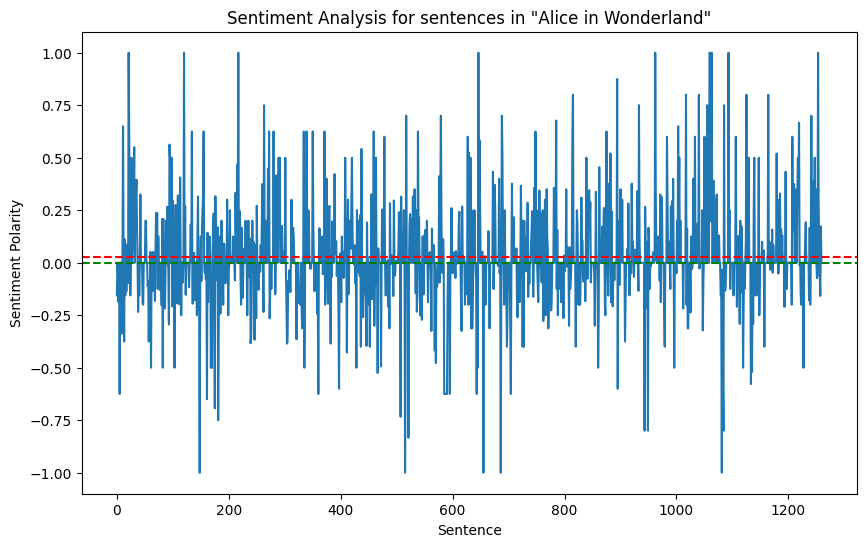

<Figure size 1000x600 with 0 Axes>

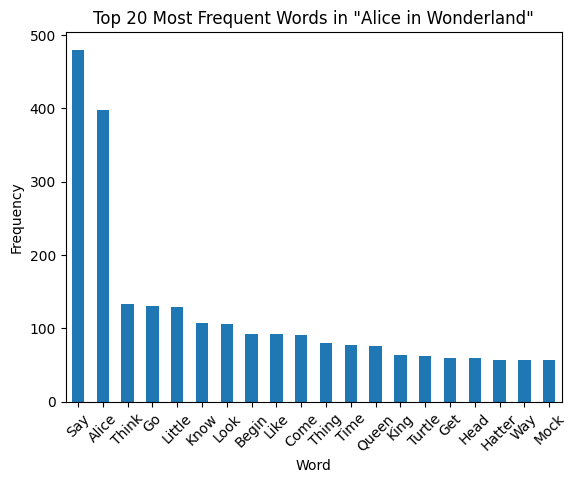

In [80]:
alice.get_analysis()


Median Sentiment: 0.032856661630831556


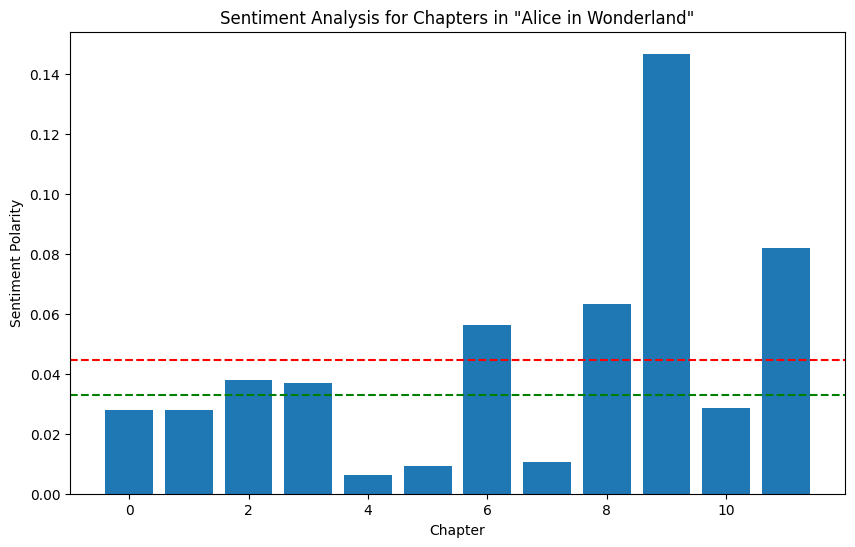

The most positive chapter was Chapter 10: 0.1466299603174603
	Tokens: deeply
		Polarity: 0.0
		Subjectivity: 0.4

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: same
		Polarity: 0.0
		Subjectivity: 0.125

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: down
		Polarity: -0.15555555555555559
		Subjectivity: 0.2888888888888889

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: delightful, !
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: first, !
		Polarity: 0.3125
		Subjectivity: 0.3333333333333333

	Tokens: generally, !
		Polarity: 0.06250000000000003
		Subjectivity: 0.5

	Tokens: same, !
		Polarity: 0.0
		Subjectivity: 0.125

	Tokens: far, !, !
		Polarity: 0.15625
		Subjectivity: 1.0

	Tokens: wildly, !
		Polarity: 0.125
		Subjectivity: 0.4

	Tokens: top
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: first
		Polarity: 0.25
		Subjectivity:

In [81]:
alice.chapter_analysis()
books.append(alice)

### The War of the Worlds

In [82]:
BookImporter.get_book(36, 'War of the Worlds')
with open('data\War_of_the_Worlds.txt', 'r', encoding='UTF-8') as file:
    war_of_the_worlds = Book('War of the Worlds', file.read())

chapter_markers = r'\n[IVX]+\.\n'


In [83]:
war_of_the_worlds.split_into_chapters(chapter_markers)


Number of chapters: 27


In [84]:
war_of_the_worlds.do_nlp(nlp)


In [85]:
war_of_the_worlds.chapter_nlp(nlp)


In [86]:
war_of_the_worlds.blobify()


Blobby Statistics for War of the Worlds
Whole Text Polarity:			0.015814684250657216
Whole Text Subjectivity:		0.46073127062093117



Basic Statistics for War of the Worlds:
	Total Tokens:			75583
	Unique Words:			40697
	Average Sentence Length:	23.738379396984925
	Average Sentence Polarity:	0.011435596127539846
	Average Sentence Subjectivity:	0.3156164445942447

Sentence with highest polarity (1.0):
It seems to me now almost
incredibly wonderful that, with that swift fate hanging over us, men
could go about their petty concerns as they did.

	Tokens: incredibly, wonderful
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
The thought of the confined creature was so dreadful to him that he
forgot the heat and went forward to the cylinder to help turn.

	Tokens: dreadful
		Polarity: -1.0
		Subjectivity: 1.0



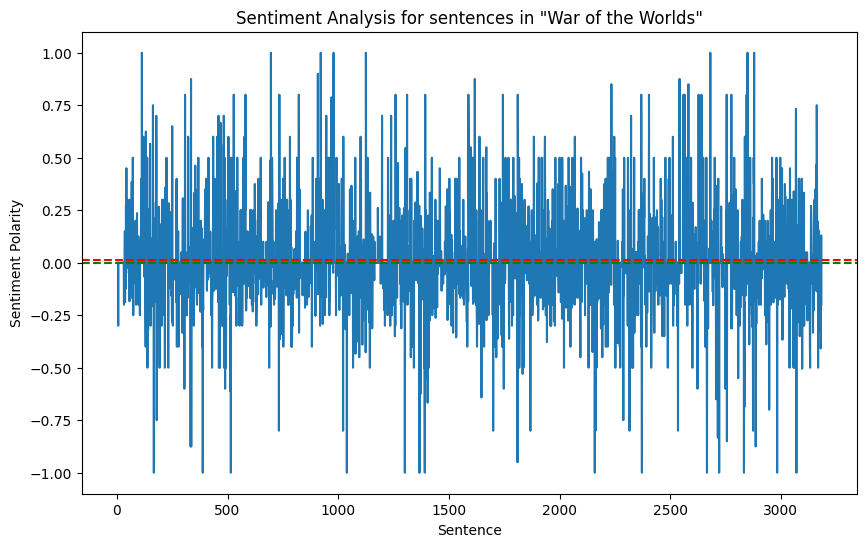

<Figure size 1000x600 with 0 Axes>

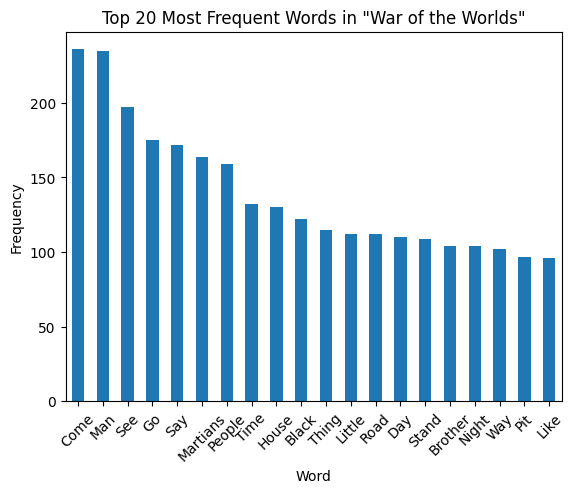

In [87]:
war_of_the_worlds.get_analysis()


Median Sentiment: 0.016110790707830183


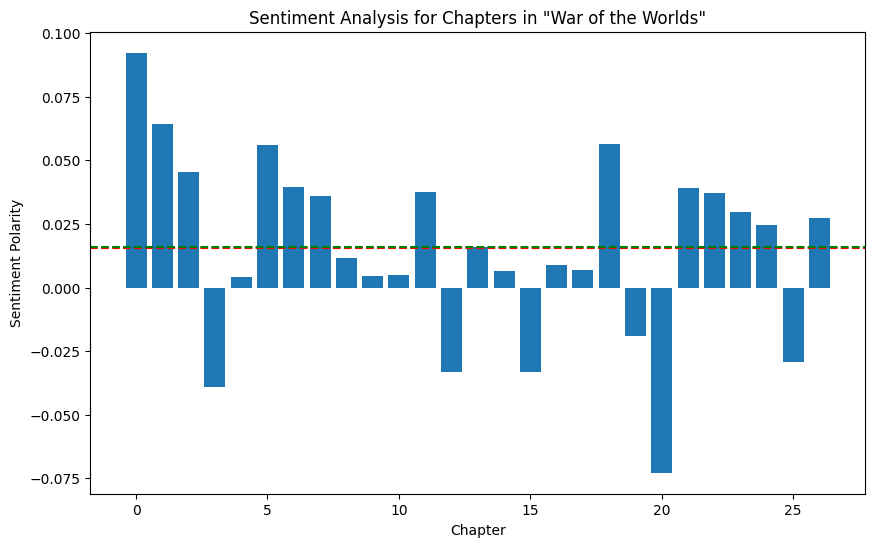

The most positive chapter was Chapter 1: 0.09231482076779107
	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: greater
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: various
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: narrowly
		Polarity: -0.2
		Subjectivity: 0.4

	Tokens: multiply
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: little
		Polarity: -0.1875
		Subjectivity: 0.5

	Tokens: possible
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: same
		Polarity: 0.0
		Subjectivity: 0.125

	Tokens: older
		Polarity: 0.16666666666666666
		Subjectivity: 0.3333333333333333

	Tokens: human
		Polarity: 0.0
		Subjectivity: 0.1

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: impossible
		Polarity: -0.6666666666666666
		Subjectivity: 1.0

	Tokens: curious
		Polarity: -0.1
		Subjectivity: 1.0

	Tokens: mental
		Polarity: -0.1
		Subjectivity: 0.2

	Tokens: most
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: terrestria

In [88]:
war_of_the_worlds.chapter_analysis()
books.append(war_of_the_worlds)

### Wuthering Heights

In [89]:
with open('data\Wuthering_Heights.txt', 'r', encoding='UTF-8') as file:
    wuthering_heights = Book('Wuthering Heights', file.read())

chapter_markers = r'CHAPTER [IVX]+'


In [90]:
wuthering_heights.split_into_chapters(chapter_markers)


Number of chapters: 34


In [91]:
wuthering_heights.do_nlp(nlp)


In [92]:
wuthering_heights.chapter_nlp(nlp)


In [93]:
wuthering_heights.blobify()


Blobby Statistics for Wuthering Heights
Whole Text Polarity:			0.04616328478907085
Whole Text Subjectivity:		0.5098336084009212



Basic Statistics for Wuthering Heights:
	Total Tokens:			155358
	Unique Words:			83982
	Average Sentence Length:	26.123759878930553
	Average Sentence Polarity:	0.024480897414461952
	Average Sentence Subjectivity:	0.3277600928638842

Sentence with highest polarity (1.0):
This is certainly a beautiful
country!

	Tokens: certainly, beautiful, !
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
“An awful Sunday,” commenced the paragraph beneath.

	Tokens: awful
		Polarity: -1.0
		Subjectivity: 1.0



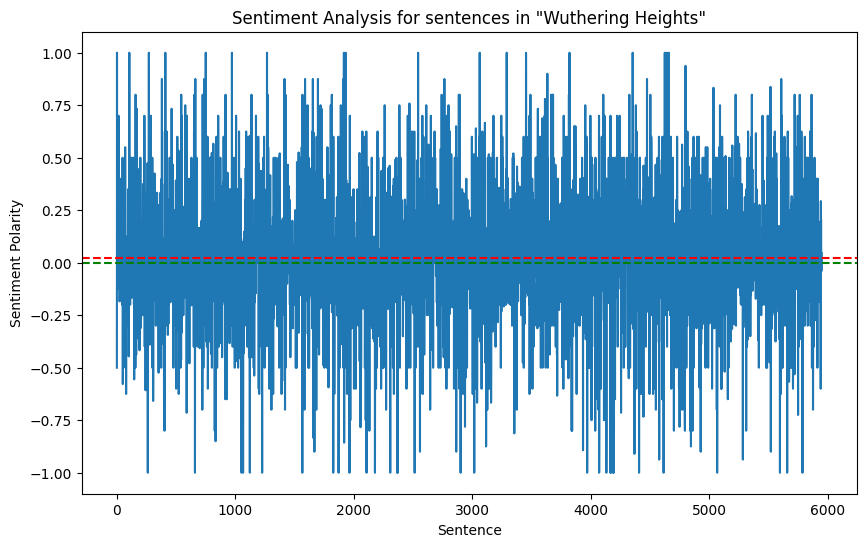

<Figure size 1000x600 with 0 Axes>

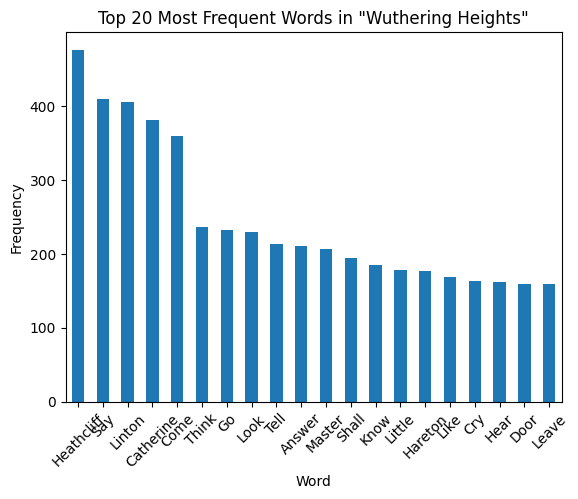

In [94]:
wuthering_heights.get_analysis()


Median Sentiment: 0.053760150375367924


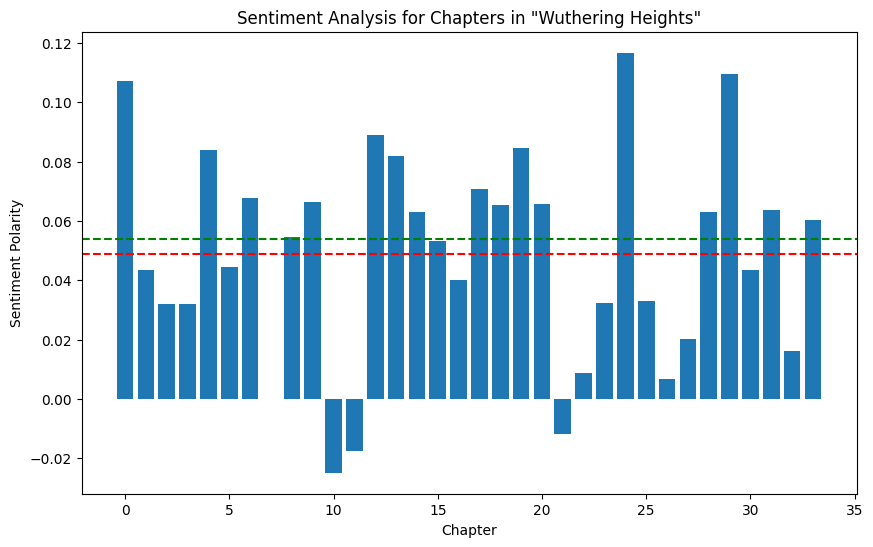

The most positive chapter was Chapter 25: 0.11674058291245788
	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: hardly, more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: amusing, !
		Polarity: 0.75
		Subjectivity: 1.0

	Tokens: long
		Polarity: -0.05
		Subjectivity: 0.4

	Tokens: young
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: not, love
		Polarity: -0.25
		Subjectivity: 0.6

	Tokens: smile
		Polarity: 0.3
		Subjectivity: 0.1

	Tokens: lively
		Polarity: 0.13636363636363635
		Subjectivity: 0.5

	Tokens: interested
		Polarity: 0.25
		Subjectivity: 0.5

	Tokens: good, !
		Polarity: 0.875
		Subjectivity: 0.6000000000000001

	Tokens: very, possible
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: love
		Polarity: 0.5
		Subjectivity: 0.6

	Tokens: love
		Polarity: 0.5
		Subjectivity: 0.6

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: busy
		Polarity: 0.1
		Subjectivity: 0.3

	Tokens: 

In [95]:
wuthering_heights.chapter_analysis()
books.append(wuthering_heights)

### Pride and Prejudice

In [96]:
with open('data\Pride_and_Prejudice.txt', 'r', encoding='UTF-8') as file:
    pride_prejudice = Book('Pride and Prejudice', file.read())

chapter_markers = r'(Chapter I\.\])|CHAPTER [IVXL]+\.'


In [97]:
pride_prejudice.split_into_chapters(chapter_markers)

Number of chapters: 58


In [98]:
pride_prejudice.do_nlp(nlp)

In [99]:
pride_prejudice.chapter_nlp(nlp)

Basic Statistics for Pride and Prejudice:
	Total Tokens:			163129
	Unique Words:			83191
	Average Sentence Length:	30.164386094674555
	Average Sentence Polarity:	0.09855736315152179
	Average Sentence Subjectivity:	0.4020423273490538

Sentence with highest polarity (1.0):
“What an excellent father you have, girls,” said she, when the door was
shut.

	Tokens: excellent
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
“Oh, shocking!” cried Miss Bingley.

	Tokens: shocking, !
		Polarity: -1.0
		Subjectivity: 1.0



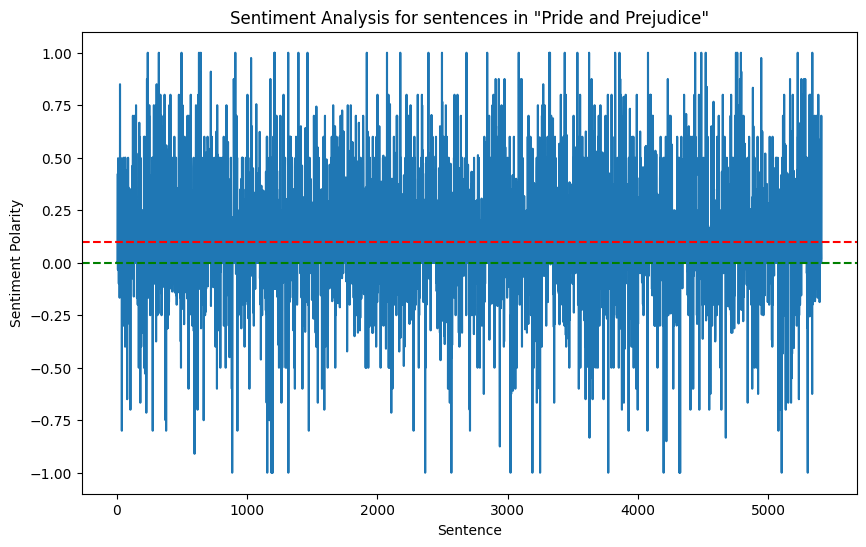

<Figure size 1000x600 with 0 Axes>

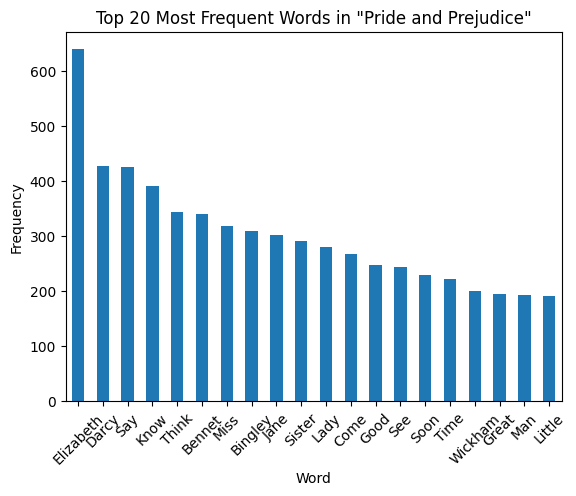

In [100]:
pride_prejudice.get_analysis()


Median Sentiment: 0.13888268770371046


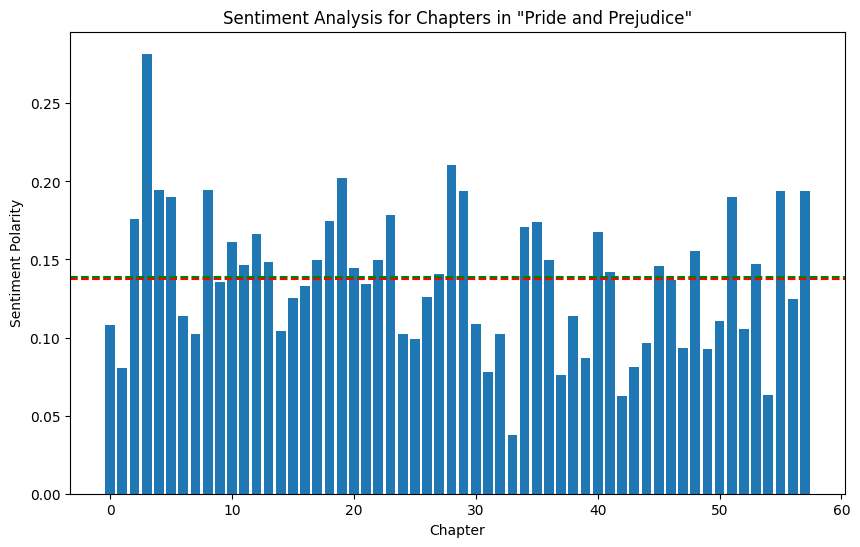

The most positive chapter was Chapter 4: 0.2817675587652224
	Tokens: former
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: very, much
		Polarity: 0.26
		Subjectivity: 0.26

	Tokens: lively
		Polarity: 0.13636363636363635
		Subjectivity: 0.5

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: happy, !
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: perfect
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: good, !
		Polarity: 0.875
		Subjectivity: 0.6000000000000001

	Tokens: handsome
		Polarity: 0.5
		Subjectivity: 1.0

	Tokens: young
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: possibly
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: complete
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: very, much
		Polarity: 0.26
		Subjectivity: 0.26

	Tokens: second
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: such
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: great
		Polarity: 0.8
		Subjectivity:

In [101]:
pride_prejudice.chapter_analysis()
books.append(pride_prejudice)

### Moby Dick

In [102]:
with open('data\Moby-Dick_or,_the_Whale.txt', 'r', encoding='UTF-8') as file:
    moby_dick = Book('Moby Dick', file.read())


In [103]:
chapter_markers = r'(\nCHAPTER .+)|(\nEPILOGUE.)'

In [104]:

moby_dick.split_into_chapters(chapter_markers)


Number of chapters: 136


In [105]:
moby_dick.do_nlp(nlp, 10000)


c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)


In [106]:
moby_dick.chapter_nlp(nlp)


In [107]:
moby_dick.blobify()


Blobby Statistics for Moby Dick
Whole Text Polarity:			0.08274175011449368
Whole Text Subjectivity:		0.47814575662913006



Basic Statistics for Moby Dick:
	Total Tokens:			278474
	Unique Words:			157024
	Average Sentence Length:	30.969083629893237
	Average Sentence Polarity:	0.05535266143153792
	Average Sentence Subjectivity:	0.32898610363932024

Sentence with highest polarity (1.0):
But I lay perfectly still, and resolved not to say a word
till spoken to.

	Tokens: perfectly
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
Yes, it’s just as I thought, he’s a terrible
bedfellow; he’s been in a fight, got dreadfully cut, and here he is,
just from the surgeon.

	Tokens: terrible
		Polarity: -1.0
		Subjectivity: 1.0

	Tokens: dreadfully
		Polarity: -1.0
		Subjectivity: 1.0



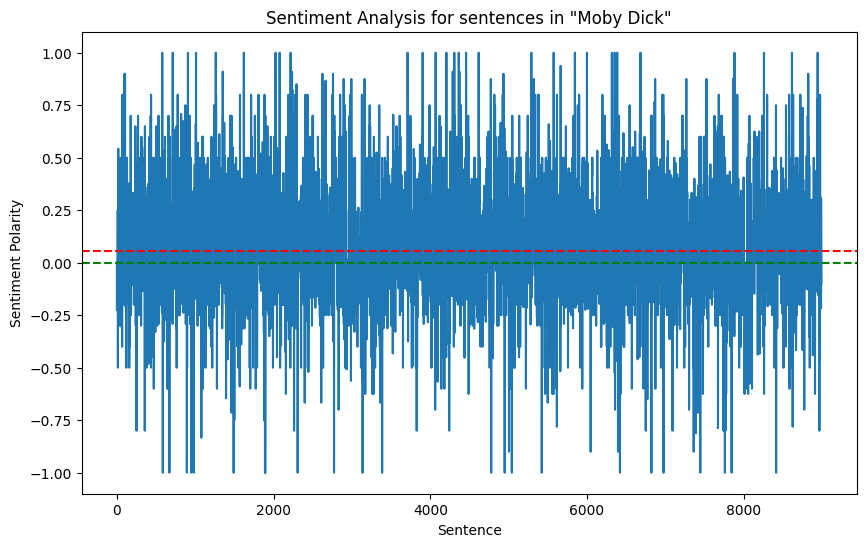

<Figure size 1000x600 with 0 Axes>

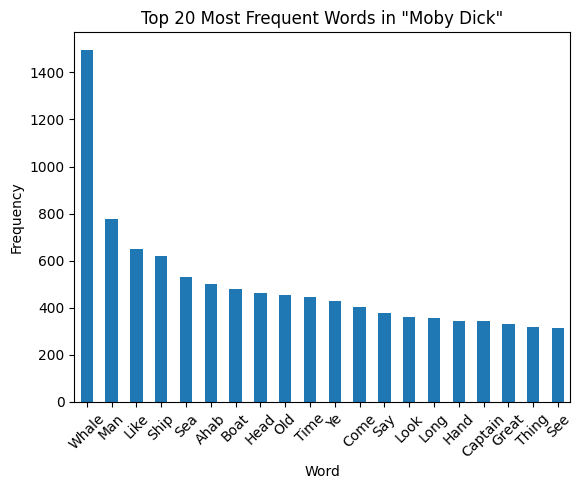

In [108]:
moby_dick.get_analysis()


Median Sentiment: 0.07831483046194432


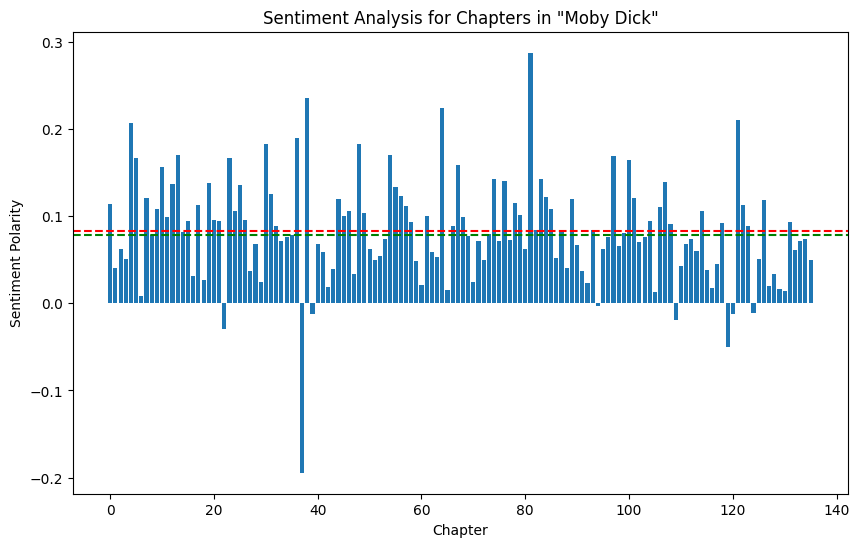

The most positive chapter was Chapter 82: 0.2878038979304802
	Tokens: careful
		Polarity: -0.1
		Subjectivity: 1.0

	Tokens: true
		Polarity: 0.35
		Subjectivity: 0.65

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: very
		Polarity: 0.2
		Subjectivity: 0.3

	Tokens: much
		Polarity: 0.2
		Subjectivity: 0.2

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: impressed
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: especially
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: many
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: other
		Polarity: -0.125
		Subjectivity: 0.375

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: not, killed
		Polarity: 0.1
		Subjectivity: 0.0

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: fine
		Polarity: 0.4166666666666667
		Subjecti

In [109]:
moby_dick.chapter_analysis()
books.append(moby_dick)

### Ulysses

In [110]:
BookImporter.get_book(4300, 'Ulysses')
with open('data\\Ulysses.txt', 'r', encoding='UTF-8') as file:
    ulysses = Book('Ulysses', file.read())


In [111]:
chapter_markers = r''
for i in range(1, 18):
    chapter_markers += r'(\n\[ {} \])|'.format(i)
chapter_markers += r'(\n\[ 18 \])'

In [112]:

ulysses.split_into_chapters(chapter_markers)


Number of chapters: 18


In [113]:
ulysses.do_nlp(nlp, 10000)


c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)


In [114]:
ulysses.chapter_nlp(nlp)


In [115]:
ulysses.blobify()


Blobby Statistics for Ulysses
Whole Text Polarity:			0.04590503747026179
Whole Text Subjectivity:		0.4782516778778993



Basic Statistics for Ulysses:
	Total Tokens:			344954
	Unique Words:			208707
	Average Sentence Length:	15.788813621384108
	Average Sentence Polarity:	0.016286736818274233
	Average Sentence Subjectivity:	0.22552822878890397

Sentence with highest polarity (1.0):
O, my name for you
is the best: Kinch, the knife-blade.



	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

Sentence with lowest polarity (-1.0):
Come up, you fearful jesuit!



	Tokens: fearful, !
		Polarity: -1.0
		Subjectivity: 1.0



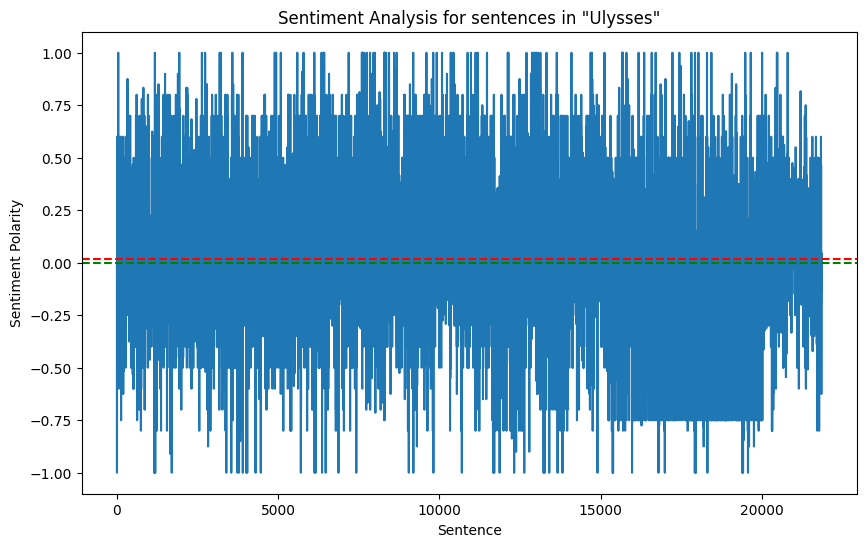

<Figure size 1000x600 with 0 Axes>

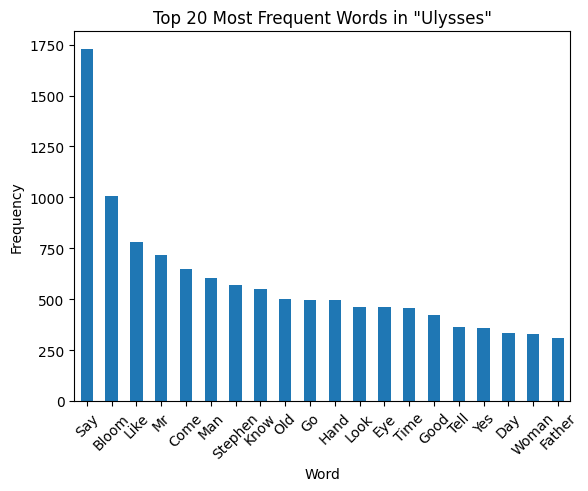

In [116]:

ulysses.get_analysis()


Median Sentiment: 0.05763528418772087


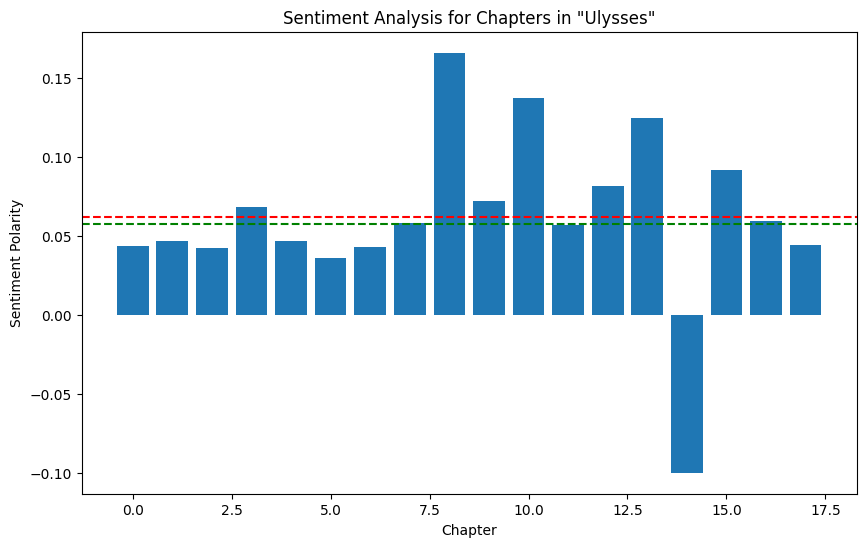

The most positive chapter was Chapter 9: 0.1660534903195309
	Tokens: priceless
		Polarity: 1.0
		Subjectivity: 1.0

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: great
		Polarity: 0.8
		Subjectivity: 0.75

	Tokens: real
		Polarity: 0.2
		Subjectivity: 0.30000000000000004

	Tokens: attendant
		Polarity: 0.2
		Subjectivity: 0.4

	Tokens: open
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: slightly
		Polarity: -0.16666666666666666
		Subjectivity: 0.16666666666666666

	Tokens: beautiful
		Polarity: 0.85
		Subjectivity: 1.0

	Tokens: grief
		Polarity: -0.8
		Subjectivity: 0.2

	Tokens: hard
		Polarity: -0.2916666666666667
		Subjectivity: 0.5416666666666666

	Tokens: true
		Polarity: 0.35
		Subjectivity: 0.65

	Tokens: true
		Polarity: 0.35
		Subjectivity: 0.65

	Tokens: larger
		Polarity: 0.0
		Subjectivity: 0.5

	Tokens: most
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: large
		Polarity: 0.21428571428571427
		Subjectivity: 0.42857142857142855

	Tokens: attendant
		Polarity:

In [117]:
ulysses.chapter_analysis()
books.append(ulysses)

### A Christmas Carol

In [118]:
with open('data\A_Christmas_Carol.txt', 'r', encoding='UTF-8') as file:
    christmas_carol = Book('A Christmas Carol', file.read())

In [119]:
chapter_markers = r'STAVE (.+)'

In [120]:
christmas_carol.split_into_chapters(chapter_markers)

Number of chapters: 5


In [121]:
christmas_carol.do_nlp(nlp)

In [122]:
christmas_carol.chapter_nlp(nlp)

In [123]:
christmas_carol.blobify()

Blobby Statistics for A Christmas Carol
Whole Text Polarity:			0.10297132260911637
Whole Text Subjectivity:		0.4994608844449129



Basic Statistics for A Christmas Carol:
	Total Tokens:			39228
	Unique Words:			21947
	Average Sentence Length:	24.875079264426127
	Average Sentence Polarity:	0.06700052780926624
	Average Sentence Subjectivity:	0.3242960917955689

Sentence with highest polarity (1.0):
But the great effect of the evening came after the Roast
and Boiled, when the fiddler (an artful dog, mind!

	Tokens: great, !
		Polarity: 1.0
		Subjectivity: 0.75

Sentence with lowest polarity (-1.0):
and in the hall appeared the schoolmaster
himself, who glared on Master Scrooge with a ferocious
condescension, and threw him into a dreadful state of mind
by shaking hands with him.

	Tokens: dreadful
		Polarity: -1.0
		Subjectivity: 1.0



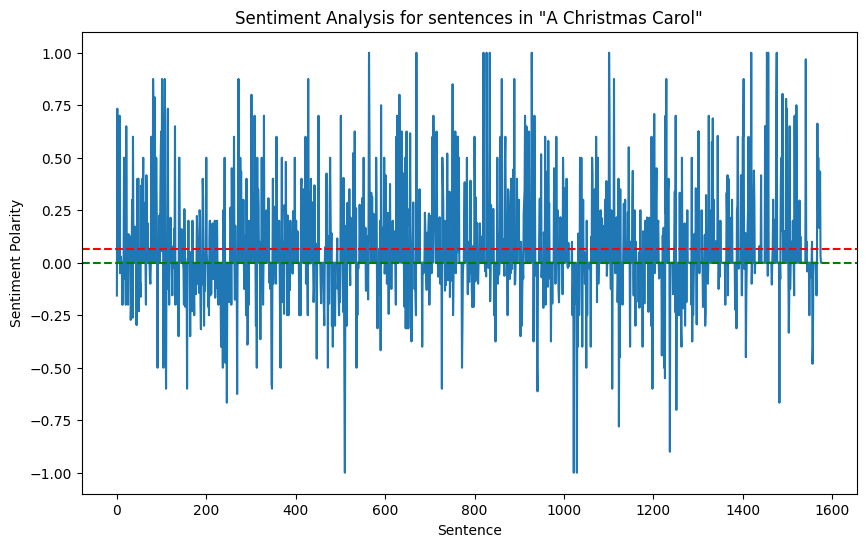

<Figure size 1000x600 with 0 Axes>

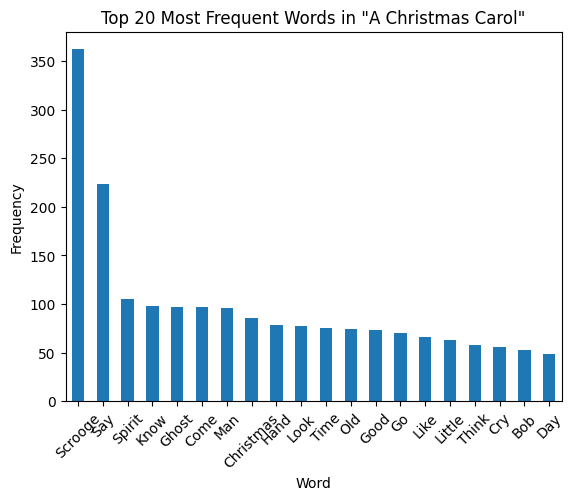

In [124]:
christmas_carol.get_analysis()

Median Sentiment: 0.10417513622901346


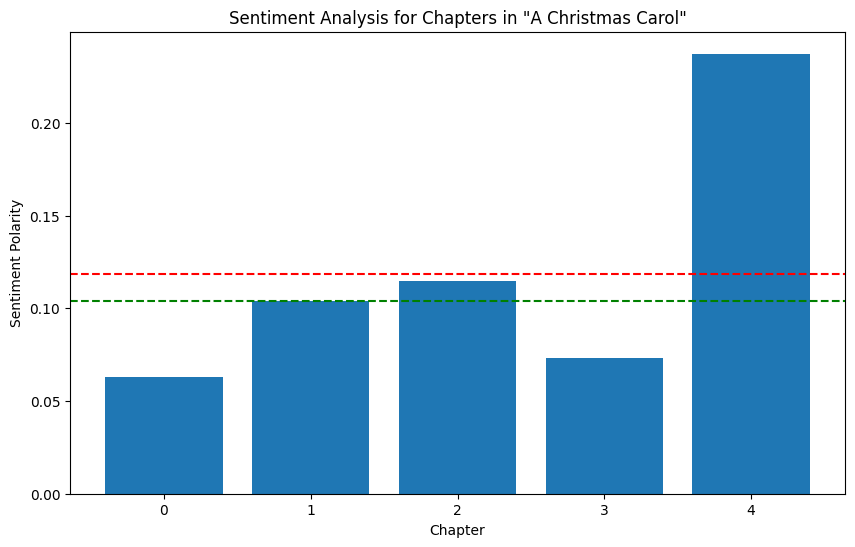

The most positive chapter was Chapter 5: 0.23729997125587265
	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: own
		Polarity: 0.6
		Subjectivity: 1.0

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

	Tokens: own, !
		Polarity: 0.75
		Subjectivity: 1.0

	Tokens: live
		Polarity: 0.13636363636363635
		Subjectivity: 0.5

	Tokens: past
		Polarity: -0.25
		Subjectivity: 0.25

	Tokens: present
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: future, !, !, !
		Polarity: 0.0
		Subjectivity: 0.125

	Tokens: old, !
		Polarity: 0.125
		Subjectivity: 0.2

	Tokens: good
		Polarity: 0.7
		Subjectivity: 0.6000000000000001

	Tokens: broken
		Polarity: -0.4
		Subjectivity: 0.4

	Tokens: violently
		Polarity: -0.8
		Subjectivity: 1.0

	Tokens: wet
		Polarity: -0.1
		Subjectivity: 0.4

	Tokens: down
		Polarity: -0.15555555555555559
		Subjectivity: 0.2888888888888889

	Tokens: down, !
		Polarity: -0.19444444444444448
		Subjectivity: 0.28888888888

In [125]:
christmas_carol.chapter_analysis()
books.append(christmas_carol)

## Dorian Grey

In [126]:
with open('data\The_Picture_of_Dorian_Gray.txt', 'r', encoding='UTF-8') as file:
    dorian_gray = Book('The Picture of Dorian Gray', file.read())


In [127]:
chapter_markers = r'\n(CHAPTER .+)'

In [128]:
dorian_gray.split_into_chapters(chapter_markers)

Number of chapters: 20


In [129]:
dorian_gray.do_nlp(nlp)

In [130]:
dorian_gray.chapter_nlp(nlp)

In [131]:
dorian_gray.blobify()

Blobby Statistics for The Picture of Dorian Gray
Whole Text Polarity:			0.06991381964989916
Whole Text Subjectivity:		0.5458973341303766



Basic Statistics for The Picture of Dorian Gray:
	Total Tokens:			103393
	Unique Words:			54941
	Average Sentence Length:	17.73464837049743
	Average Sentence Polarity:	0.037681878949243096
	Average Sentence Subjectivity:	0.345837711028256

Sentence with highest polarity (1.0):
“It is your best work, Basil, the best thing you have ever done,” said
Lord Henry languidly.

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

	Tokens: best
		Polarity: 1.0
		Subjectivity: 0.3

Sentence with lowest polarity (-1.0):
I suppose you think me awfully foolish about it?”

“Not at all,” answered Lord Henry, “not at all, my dear Basil.

	Tokens: awfully
		Polarity: -1.0
		Subjectivity: 1.0



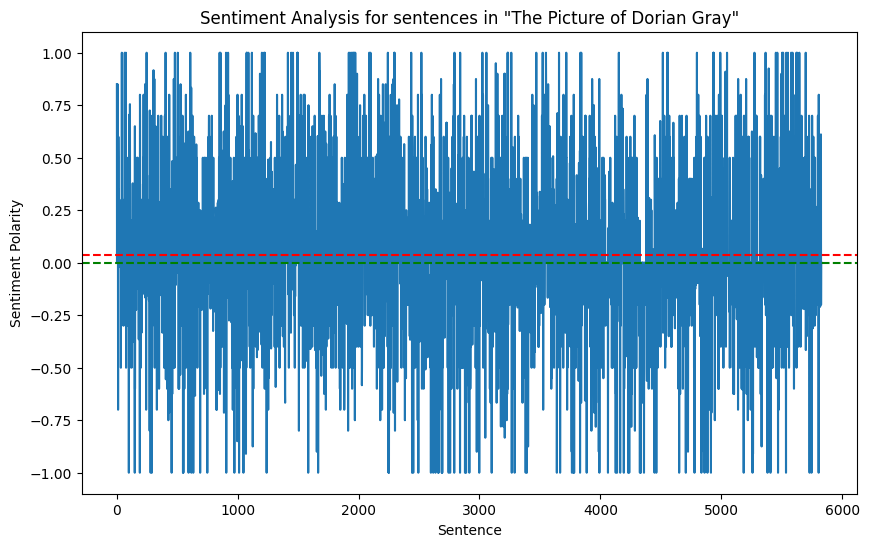

<Figure size 1000x600 with 0 Axes>

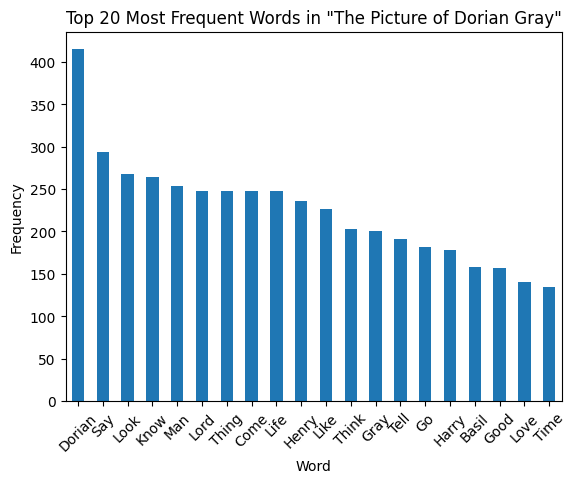

In [132]:
dorian_gray.get_analysis()

Median Sentiment: 0.07460245240485006


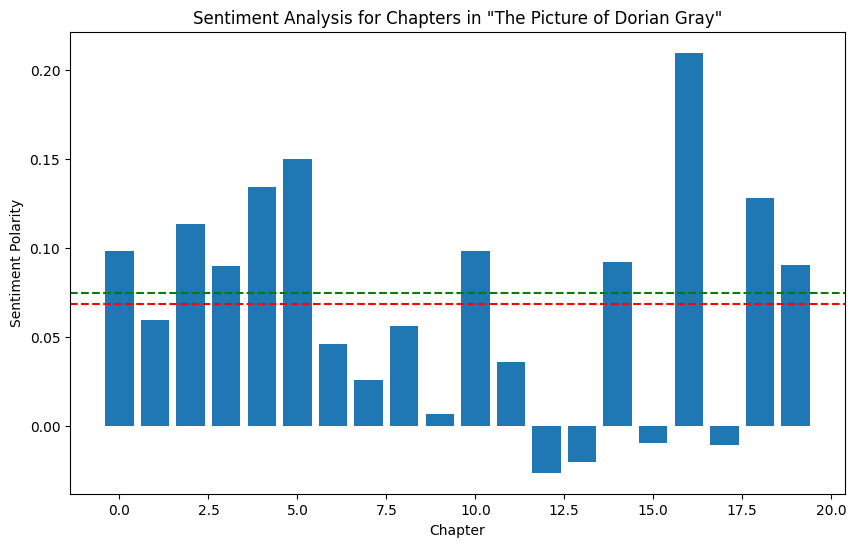

The most positive chapter was Chapter 17: 0.20963250342386375
	Tokens: later
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: pretty
		Polarity: 0.25
		Subjectivity: 1.0

	Tokens: light
		Polarity: 0.4
		Subjectivity: 0.7

	Tokens: huge
		Polarity: 0.4000000000000001
		Subjectivity: 0.9

	Tokens: delicate
		Polarity: -0.3
		Subjectivity: 0.9

	Tokens: white
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: daintily
		Polarity: 0.9
		Subjectivity: 1.0

	Tokens: full
		Polarity: 0.35
		Subjectivity: 0.55

	Tokens: red
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: back
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: last
		Polarity: 0.0
		Subjectivity: 0.06666666666666667

	Tokens: young
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: elaborate
		Polarity: 0.5
		Subjectivity: 1.0

	Tokens: more
		Polarity: 0.5
		Subjectivity: 0.5

	Tokens: expected
		Polarity: -0.1
		Subjectivity: 0.4

	Tokens: next
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: down
		Polarity: -0.15555555555555559
		Subjectivity: 0

In [133]:
dorian_gray.chapter_analysis()
books.append(dorian_gray)

## War and Peace

In [134]:
with open('data\War_and_Peace.txt', 'r', encoding='UTF-8') as file:
    war_and_peace = Book('War and Peace', file.read())


In [135]:
chapter_markers = r'\nCHAPTER [IXVC]+\n'

In [136]:
war_and_peace.split_into_chapters(chapter_markers)

Number of chapters: 365


In [137]:
war_and_peace.do_nlp(nlp)

c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'blob' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'polarity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'subjectivity' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)
c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\language_analysis.py:73: UserWarning: [W101] Skipping Doc custom extension 'assessments' while merging docs.
  return spacy.tokens.Doc(nlp.vocab).from_docs(docs)


In [138]:
war_and_peace.chapter_nlp(nlp)

In [139]:
war_and_peace.blobify()

Blobby Statistics for War and Peace
Whole Text Polarity:			0.08250239526102147
Whole Text Subjectivity:		0.47372584916506794



Basic Statistics for War and Peace:
	Total Tokens:			724851
	Unique Words:			392509
	Average Sentence Length:	24.660667505868744
	Average Sentence Polarity:	0.05047073350428187
	Average Sentence Subjectivity:	0.30565683770392355

Sentence with highest polarity (1.0):
“The vicomte is a wonderful raconteur,” said she
to another.

	Tokens: wonderful
		Polarity: 1.0
		Subjectivity: 1.0

Sentence with lowest polarity (-1.0):
“Oh, how dreadful!

	Tokens: dreadful, !
		Polarity: -1.0
		Subjectivity: 1.0



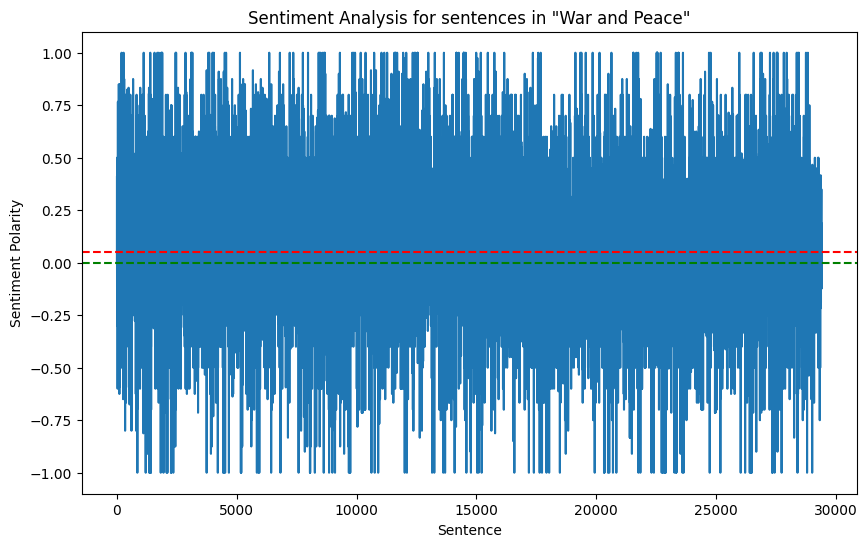

<Figure size 1000x600 with 0 Axes>

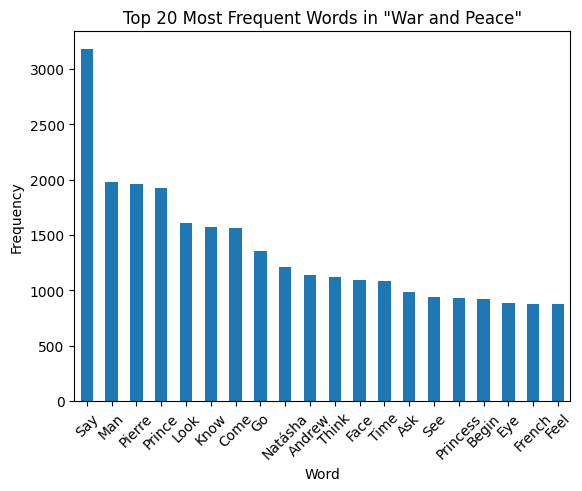

In [140]:
war_and_peace.get_analysis()

Median Sentiment: 0.07514770344959018


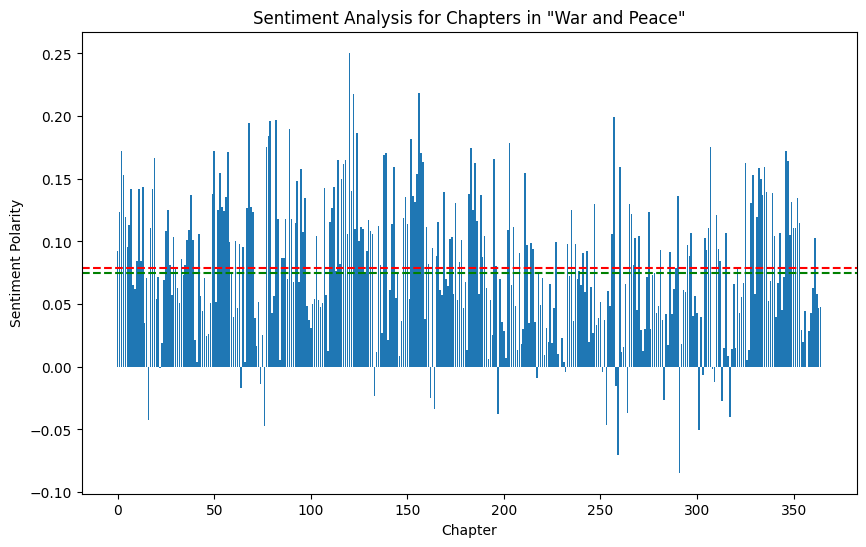

The most positive chapter was Chapter 121: 0.2505470238095238
	Tokens: free
		Polarity: 0.4
		Subjectivity: 0.8

	Tokens: early
		Polarity: 0.1
		Subjectivity: 0.3

	Tokens: first
		Polarity: 0.25
		Subjectivity: 0.3333333333333333

	Tokens: vividly
		Polarity: 0.125
		Subjectivity: 0.75

	Tokens: brightly
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: brilliant
		Polarity: 0.9
		Subjectivity: 1.0

	Tokens: young
		Polarity: 0.1
		Subjectivity: 0.4

	Tokens: splendid
		Polarity: 0.8333333333333334
		Subjectivity: 1.0

	Tokens: hardly
		Polarity: -0.2916666666666667
		Subjectivity: 0.5416666666666666

	Tokens: true
		Polarity: 0.35
		Subjectivity: 0.65

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: red
		Polarity: 0.0
		Subjectivity: 0.0

	Tokens: brightly
		Polarity: 0.7000000000000001
		Subjectivity: 0.7999999999999999

	Tokens: only
		Polarity: 0.0
		Subjectivity: 1.0

	Tokens: indispensable
		Polarity: 0.4
		Subjectivity: 0.9

	Tokens: such

In [141]:
war_and_peace.chapter_analysis()
books.append(war_and_peace)

## Conduct similarity analysis and display results

In [142]:
# Do a similarity analysis between each book in the books list
checker = SimilarityChecker(books)
checker.calculate_all_similarities()


c:\Users\RuyZambrano\OneDrive - JCW Resourcing\Desktop\Python\sentiment analysis\similarity.py:12: UserWarning: [W008] Evaluating Span.similarity based on empty vectors.
  first_sentence.similarity(second_sentence)


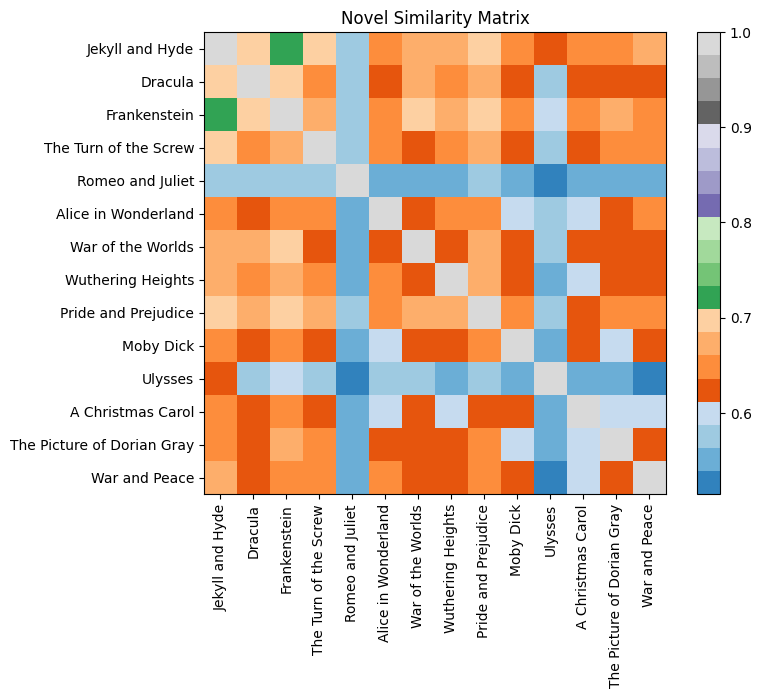

In [143]:
# Show the results of the similarity analysis
checker.display_matrix()